<a href="https://colab.research.google.com/github/abhishek-AI2001/LSTM-Text-Summarization-Amazon-Fine-Food-Reviews-/blob/main/LSTM-Text-Summarization-Amazon-Fine-Food-Reviews-%20/Notebook/LSTM_TEXT_SUMMARIZATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Summarization using LSTM

Project Overview

Customer reviews on e-commerce platforms like Amazon are often long and detailed, making manual analysis time-consuming and inefficient. To address this, Natural Language Processing (NLP) techniques can be applied to automatically generate concise summaries that capture the key insights from lengthy reviews.

This project focuses on developing an intelligent text summarization system for the Amazon Fine Food Reviews dataset using both abstractive and extractive approaches.

Objectives

- To understand the concept and types of text summarization.

- To perform text pre-processing for cleaning and preparing the data.

- To build an Abstractive Text Summarization model using LSTM with Encoder-Decoder architecture.

- To implement an Extractive Text Summarization model using Transformer architecture.

- To compare and evaluate both approaches based on their ability to generate meaningful summaries.

Concept Overview

Text Summarization is a key application of NLP that automatically generates a short, informative summary from a large body of text, allowing readers to grasp the essential content quickly.

There are two main types of summarization:

**Abstractive Summarization:** Generates new phrases or sentences that convey the meaning of the original text. The generated summary may contain rephrased or newly formed sentences not present in the source.

**Extractive Summarization:** Selects and extracts the most relevant sentences or phrases directly from the source text to form the summary.

Technical Details

The Abstractive model is built using an LSTM Encoder-Decoder architecture with a custom attention layer (since Keras does not natively support attention).

The Extractive model leverages a Transformer-based approach to identify and extract key sentences.

Project Pipeline

1. Understanding Text Summarization

2. Text Pre-processing

3. Abstractive Summarization using LSTM (Encoder-Decoder)

4. Extractive Summarization using Transformer

Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from attention import AttentionLayer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Dataset Description

The dataset used in this project is the Amazon Fine Food Reviews Dataset, which contains detailed product reviews collected over more than 10 years, up to October 2012.
It includes approximately 500,000 reviews covering various product categories on Amazon, with the following key information:

- Product details

- User information

- Ratings

- Full text reviews

- Short review summaries

For this project, we use a sample of 50,000 reviews to ensure efficient model training while maintaining sufficient data variety and representativeness.

This dataset provides rich text data suitable for building and evaluating both abstractive and extractive text summarization models.

In [ ]:
data = pd.read_csv("/content/SAMPLE_REVIEWS.csv")

In [ ]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,146376,B001H0ADJ0,A1ODOGXEYECQQ8,Nuknuk,1,1,4,1235001600,Cheese and Garlic - Flavorful and Tasty,"My wife is in love with this cheesy garlicky spread. I am the garlic lover and she is not, which baffles me a bit. I love the smell of the stinky rose as they call it, when I cook or when it is fr..."
1,12032,B0081GVC98,A1L812DW0UY9PJ,nora,0,0,5,1348444800,EEEWWWW,"These flavors are so realistic! The rotten egg and sprout flavors almost made me vomit! now when i think of the rotten egg, i feel dizzy. The cake, roasted marshmallow, and cherry ones are SO good..."
2,76951,B001OCKIP0,A2KBFB6A2D7PNO,"Totally Honest Reviewer ""barb""",0,0,5,1243555200,Delicious combination!,"Back to Nature Chocolate Delight Granola is a combination of very dark chocolate and crunchy granola. At 220 calories per one-half cup, it cannot be considered low-calorie. It has a saturated fa..."


In [ ]:
data.shape

(50050, 10)

Drop Duplicates and NA values

In [ ]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

Text Pre-processing

Before building the model, it is essential to perform text pre-processing to clean and prepare the data for training.
Raw text data often contains unnecessary symbols, punctuation, HTML tags, and other noise that can negatively impact model performance.

In this stage, we focus on removing irrelevant characters, normalizing text, and ensuring the data is in a consistent format suitable for the summarization model.

Additionally, we will handle text contractions (e.g., “can’t” → “cannot”, “don’t” → “do not”) to make the text more uniform and meaningful.
For this purpose, we will use a dictionary of contractions that maps short forms to their expanded equivalents.

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below pre-processing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove single characters

Let’s define the function for performing the above pre-processing steps

In [ ]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Cleaning the "Text" Column

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0))

Let us look at the first 2 preprocessed reviews

In [ ]:
cleaned_text[:2]

['wife love cheesy garlicky spread garlic lover baffles bit love smell stinky rose call cook fried comes peanuts tasty would say although expert cheese side gourmet like crumbly texture instead spreading smoothly bread cracker crumbles apart box product nicely wrapped classy aluminum foil make sure shop around price',
 'flavors realistic rotten egg sprout flavors almost made vomit think rotten egg feel dizzy cake roasted marshmallow cherry ones good though would recomand anyone try black ones']

In [ ]:
# Cleaning the "Summary" Column

cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

Let us look at the first 2 preprocessed summaries

In [ ]:
cleaned_summary[:2]

['cheese and garlic flavorful and tasty', 'eeewwww']

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

Drop empty rows

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

Understanding the Distribution of Sequences

In this step, we analyze the length distribution of both the review texts and their corresponding summaries.
Understanding how long the reviews and summaries typically are helps us decide on suitable maximum sequence lengths for input (reviews) and output (summaries).

Setting appropriate sequence limits ensures that our model efficiently processes the data — capturing enough context without wasting computational resources on overly long or rare cases.

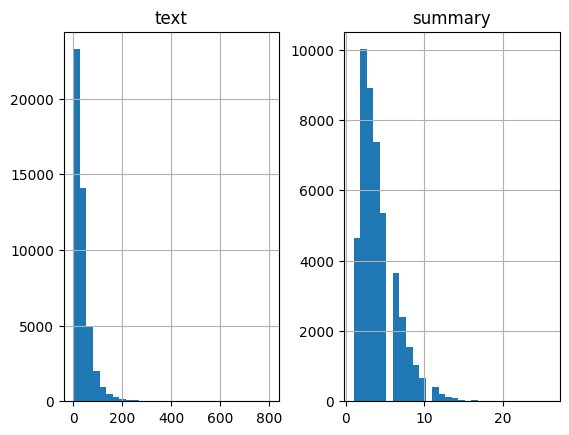

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

NOTE: We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split()) <= 8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9433897357614328


We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split()) <= 30):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.5528154630087506


Let us fix the maximum length of review to 30

In [ ]:
max_text_len=30
max_summary_len=8

We select only the reviews and summaries whose lengths are within the defined maximum limits (max_text_len and max_summary_len).

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary}) # new dataframe to use

We prepend a START token (sostok) and append an END token (eostok) to each summary to help the model identify where the sequence begins and ends.

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,text,summary
0,flavors realistic rotten egg sprout flavors almost made vomit think rotten egg feel dizzy cake roasted marshmallow cherry ones good though would recomand anyone try black ones,sostok eeewwww eostok
1,appears problem reported product corrected last order wonderful order product,sostok think thin chunky peanut bar eostok
2,used looooove stuff changed recipe waxy kind tastes like hershey also tastes less like chocolate skip chocolate buy something else worth money,sostok not good eostok
3,short sweet oatmeal delicious none better however get supermarket around five dollars quite often discount stores less love roland products price waaay line,sostok great oatmeal but the price is too high eostok
4,claim professional food taster know like like like yellow popcorn like microwave popcorn like white popcorn cooked pan popping style baby white pops great lots hard kernels nuf said,sostok great popcorn eostok


Train-Test Split and Prepare the Tokenizer

In [ ]:
from sklearn.model_selection import train_test_split

x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=0, shuffle=True)

# A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.
# We will now build tokenizers for text and summary.

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

Rare Words and Coverage in Reviews

We identify rare words in the Reviews column using a threshold of 4.
Any word that appears fewer than 4 times is considered rare. This helps in reducing vocabulary size and improving model efficiency.

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

% of rare words in vocabulary: 66.80127066171325
Total Coverage of rare words: 4.224526534195979


In [ ]:
print(cnt),print(tot_cnt)

12407
18573


(None, None)

In [ ]:
print(freq),print(tot_freq)

17225
407738


(None, None)

NOTE:

tot_cnt gives the size of vocabulary (which means every unique words in the text)

cnt gives me the no. of rare words whose count falls below threshold

tot_cnt - cnt gives me the top most common words

Let us define the tokenizer with top most common words for reviews

Reviews Tokenizer

In [ ]:
# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

In [ ]:
x_voc

6167

Summary Tokenizer

In [ ]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

Rarewords and its Coverage on the summary column

The threshold is taken as 6 which means word whose count is below 6 is considered as a rare word

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 80.76079005120702
Total Coverage of rare words: 7.727701045018125


In [ ]:
print(cnt),print(tot_cnt)

5520
6835


(None, None)

In [ ]:
print(freq),print(tot_freq)

9103
117797


(None, None)

Let us define the tokenizer with top most common words for summary.

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

#deleting the rows that contain only START and END tokens

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

Abstractive Text Summarization – Model Building

We are now ready to build the model. Before diving into code, lets clarify some important LSTM concepts used in the architecture:

Return Sequences = True: LSTM outputs the hidden state and cell state for every timestep.

Return State = True: LSTM outputs the hidden state and cell state of the last timestep only.

Initial State: Used to initialize the internal states of the LSTM for the first timestep.

Stacked LSTM: Multiple LSTM layers stacked on top of each other, which helps capture more complex sequence patterns.

In this project, we are building a 3-layer stacked LSTM for the encoder to better represent the input sequences before feeding them to the decoder.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed, Concatenate, Attention

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer
enc_emb = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM layers
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None,))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Built-in Attention layer
attn_layer = Attention(name='attention_layer')
# Keras Attention expects: [query, value] -> query=decoder, value=encoder
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# Concatenate attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 30, 100)   │    616,700 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ [(None, 30, 300), │    481,200 │ embedding_4[0][0] │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ [(None, 30, 300), │    721,200 │ lstm_8[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, None, 100) │    131,600 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ [(None, 30, 300), │    721,200 │ lstm_9[0][0]      │
│                     │ (None, 300),      │            │                   │
│                     │ (None, 300)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ [(None, None,     │    481,200 │ embedding_5[0][0… │
│                     │ 300), (None,      │            │ lstm_10[0][1],    │
│                     │ 300), (None,      │            │ lstm_10[0][2]     │
│                     │ 300)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 300) │          0 │ lstm_11[0][0],    │
│ (Attention)         │                   │            │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 600) │          0 │ lstm_11[0][0],    │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, None,      │    790,916 │ concat_layer[0][… │
│ (TimeDistributed)   │ 1316)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,944,016 (15.05 MB)

 Trainable params: 3,944,016 (15.05 MB)

 Non-trainable params: 0 (0.00 B)

Sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

EarlyStopping monitors the validation loss (val_loss). Our model will stop training once the validation loss increases.

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

Fit the model

In [62]:
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=128,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                   )

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - loss: 3.4899 - val_loss: 2.6196
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - loss: 2.6269 - val_loss: 2.6121
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - loss: 2.5869 - val_loss: 2.5352
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - loss: 2.5324 - val_loss: 2.4884
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - loss: 2.4796 - val_loss: 2.4299
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 361s 2s/step - loss: 2.4255 - val_loss: 2.3732
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - loss: 2.3497 - val_loss: 2.3338
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - loss: 2.3199 - val_loss: 2.3057
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - loss: 2.2928 - val_loss: 2.2841
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 355s 2s/step - loss: 2.2754 - val_loss: 2.2584
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - loss: 2.2215 - val_loss: 2.2394
Epoch 12/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 

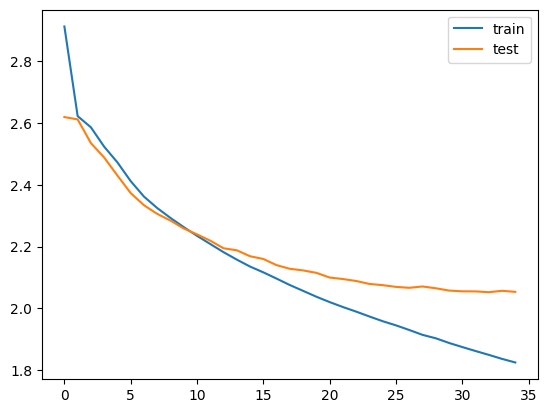

In [63]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [64]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

Inference

Set up the inference for the encoder and decoder:

In [83]:
# Decoder setup
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# Attention layer
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])

# Concatenate attention output and decoder LSTM output
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Dense layer to generate probability distribution over target vocab
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs, decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2]
)


We are defining a function below which is the implementation of the inference process

In [85]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [86]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Here are a few summaries generated by the model:

In [89]:
for i in range(0, 15):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: tea tastes great soothing one teas reach want relax 
Original summary: tea lemon 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted summary:  great tea


Review: three dogs love well bars break easily used training treat 
Original summary: all my dogs have loved these 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted summary:  dog loves them


Review: ingredients simple pure one brands add unnecessary additives generally like make sauce scratch second choice short time taste good artificially sweet love products including tomato paste 
Original summary: next best thing to fresh tomatoes 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━

**Finally, Our model is able to generate a meaningful summary based on the context present in the text.**